<a href="https://www.kaggle.com/code/ayeshairshadcoder/house-price-prediction-competition?scriptVersionId=154955920" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sample_submission=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
train.shape

(1460, 81)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [9]:
train.pop("Id")

0          1
1          2
2          3
3          4
4          5
        ... 
1455    1456
1456    1457
1457    1458
1458    1459
1459    1460
Name: Id, Length: 1460, dtype: int64

In [10]:
train["MasVnrArea"]=pd.to_numeric(train["MasVnrArea"],errors="coerce")
train["GarageYrBlt"]=pd.to_numeric(train["GarageYrBlt"],errors="coerce")
train["LotFrontage"]=pd.to_numeric(train["LotFrontage"],errors="coerce")

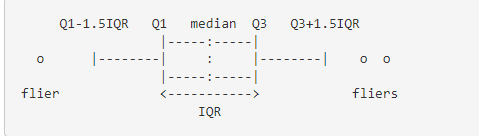

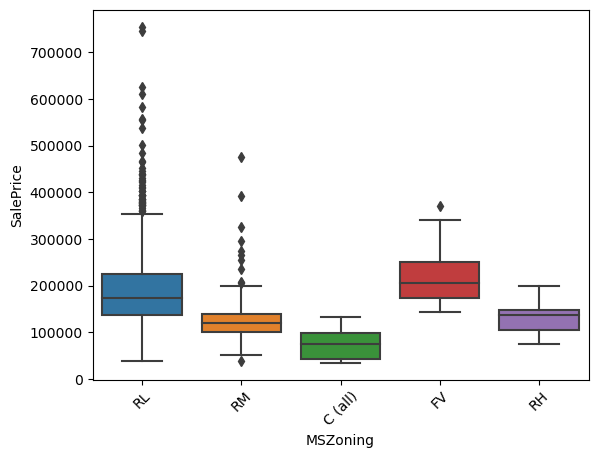

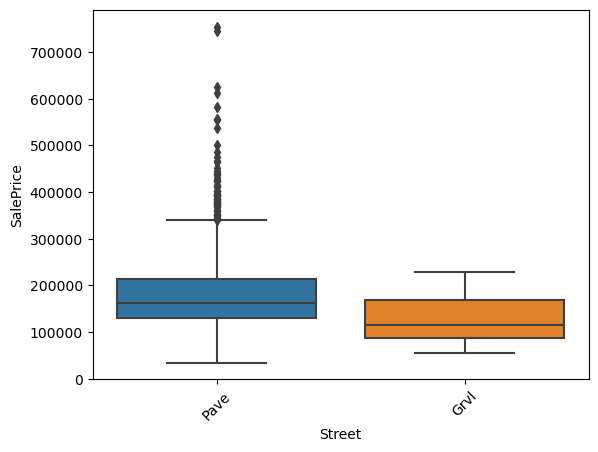

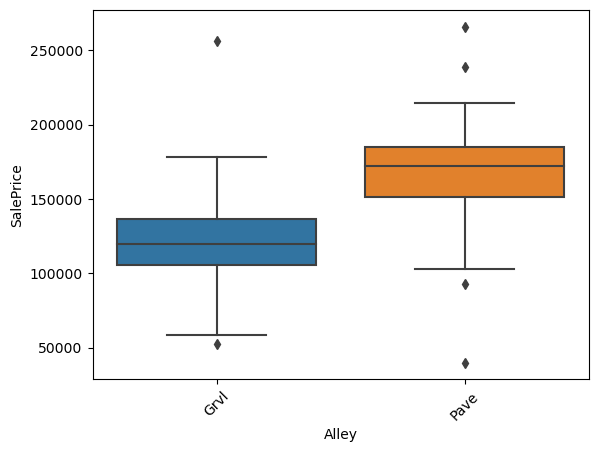

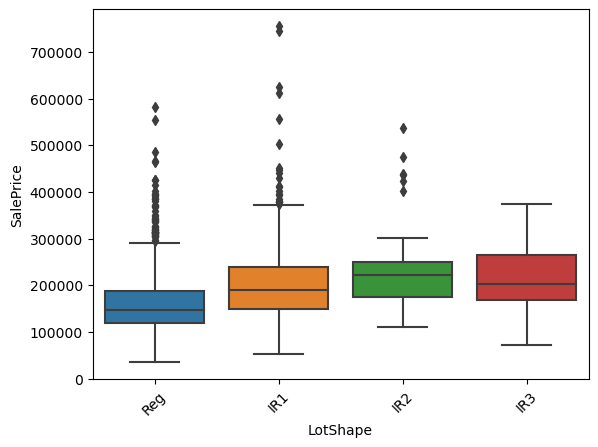

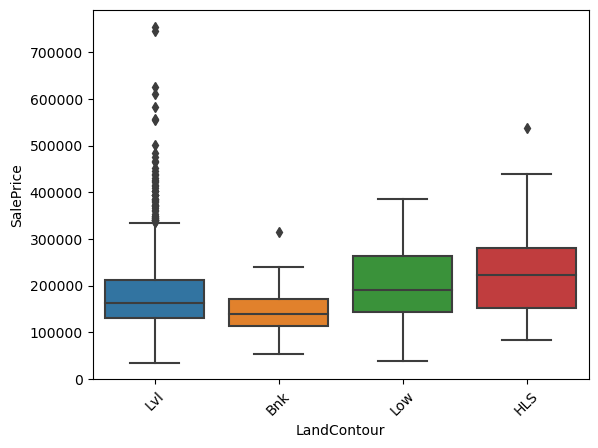

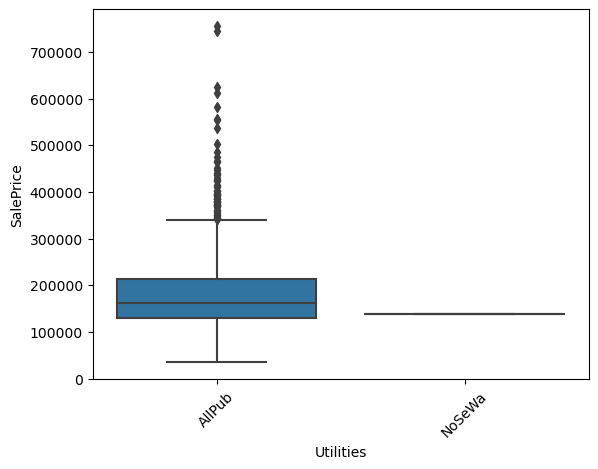

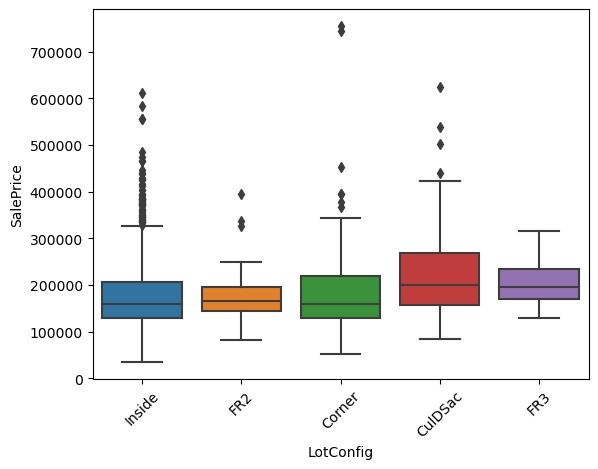

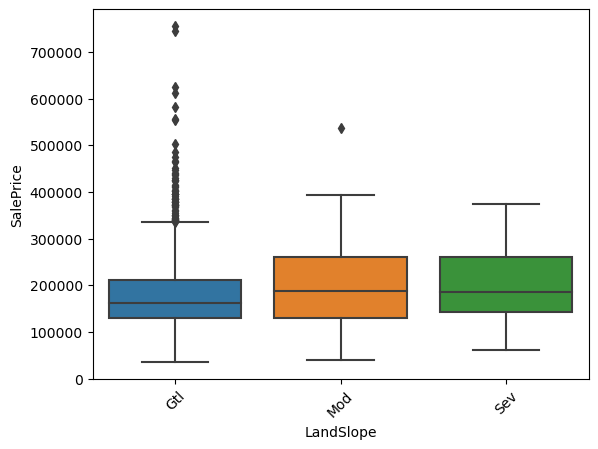

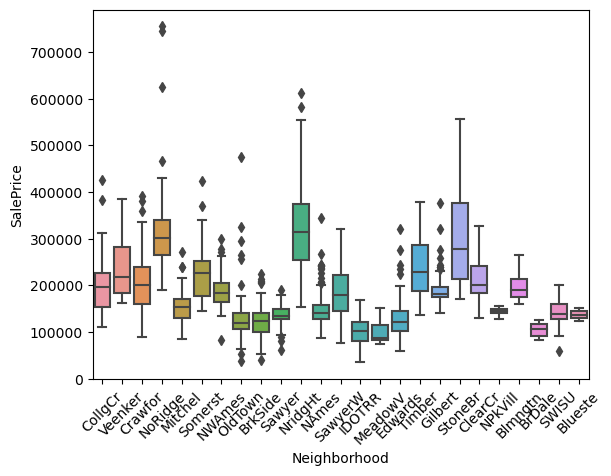

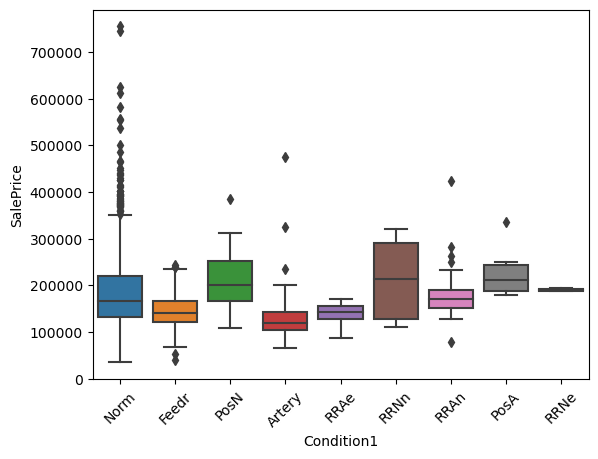

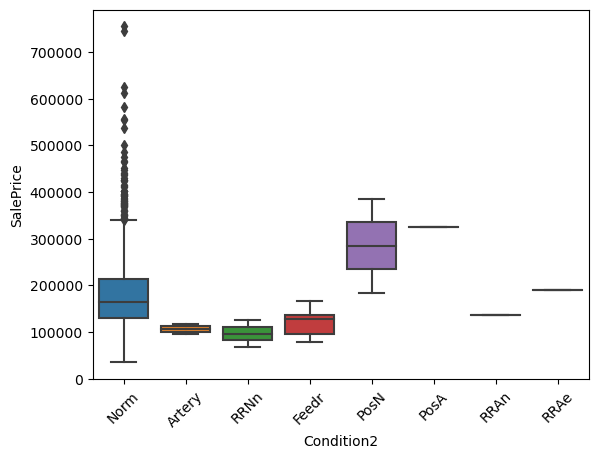

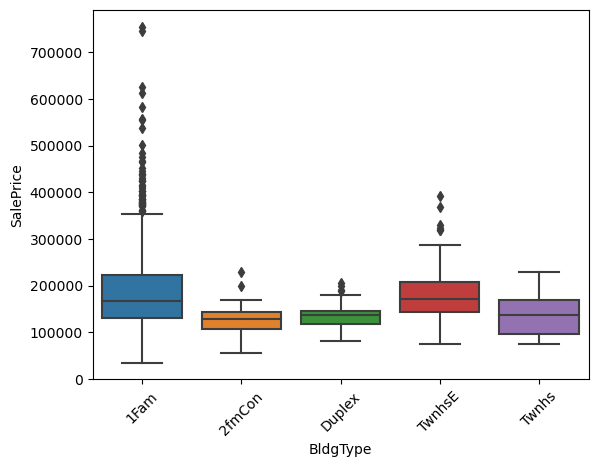

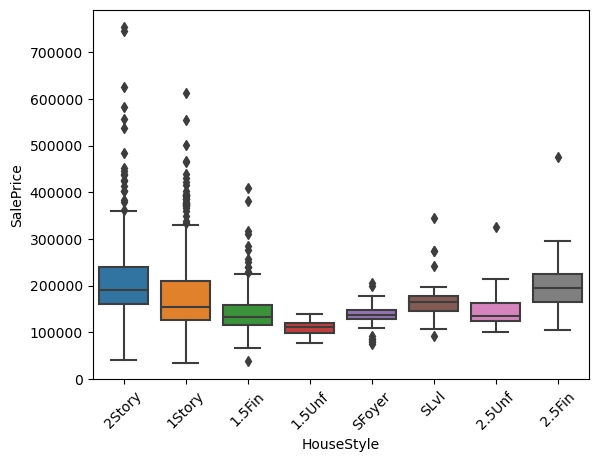

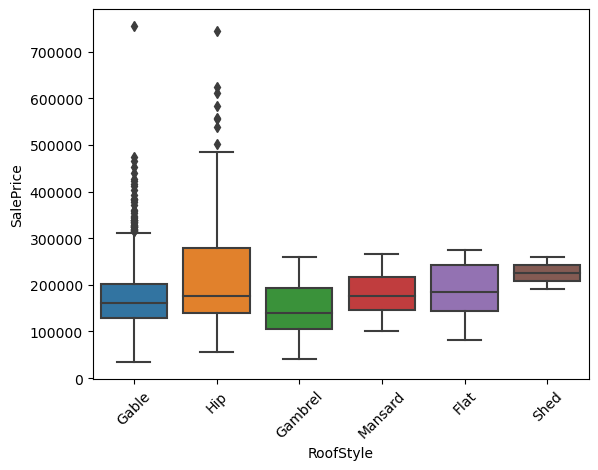

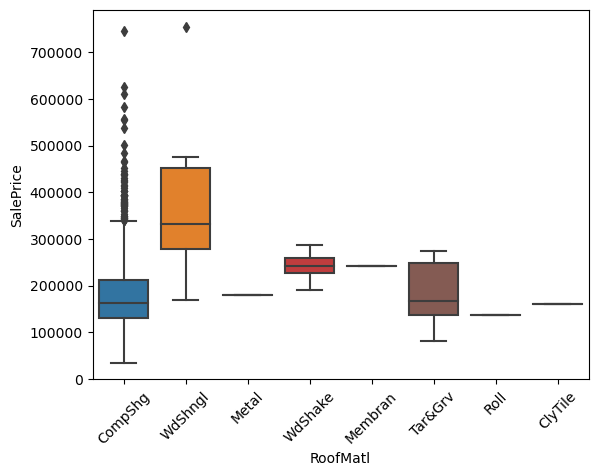

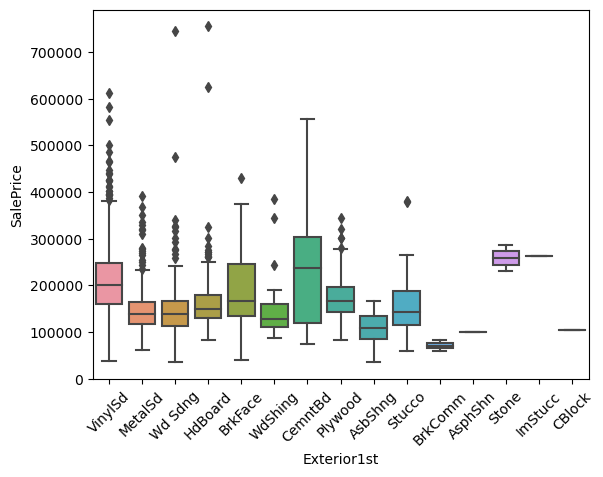

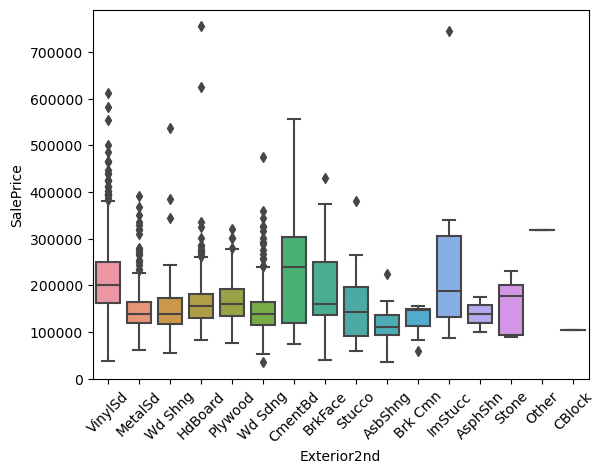

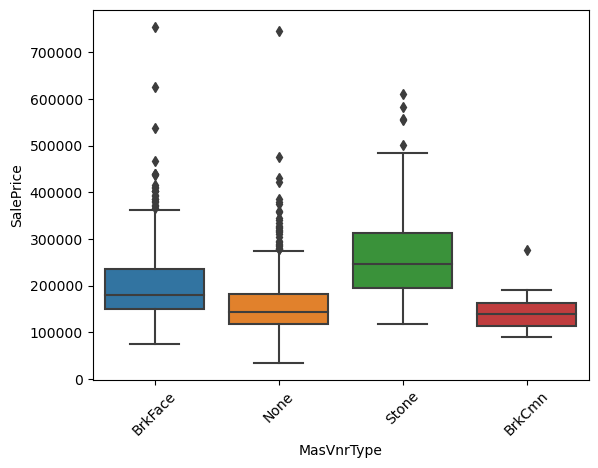

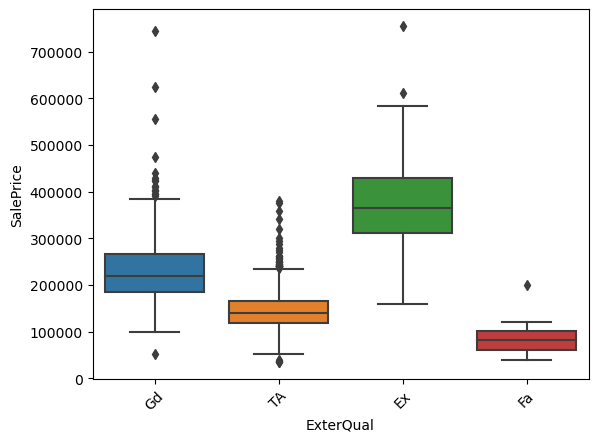

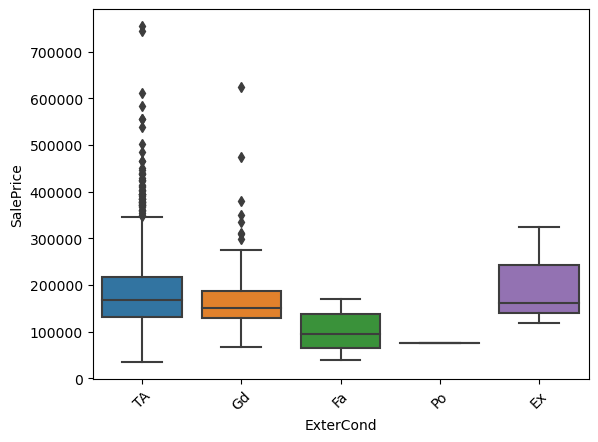

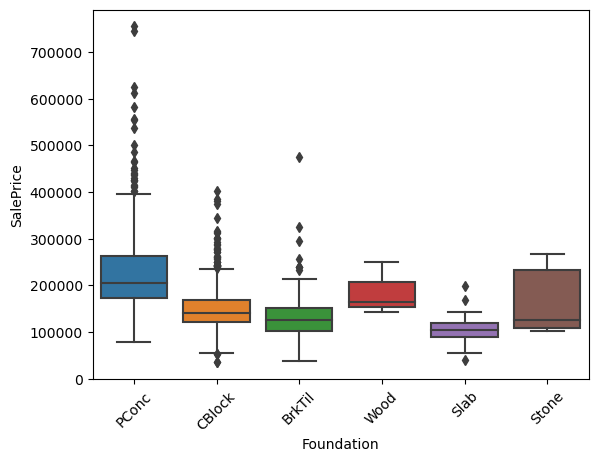

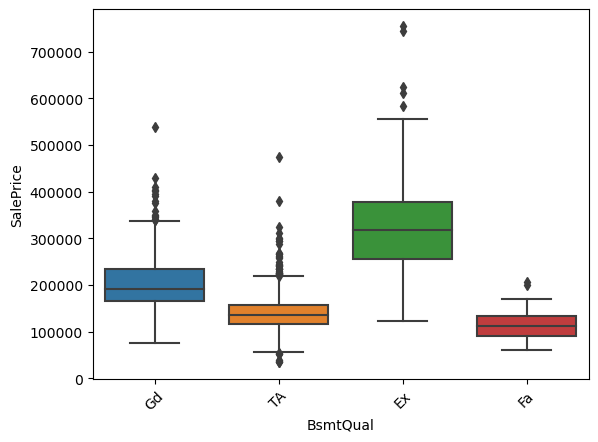

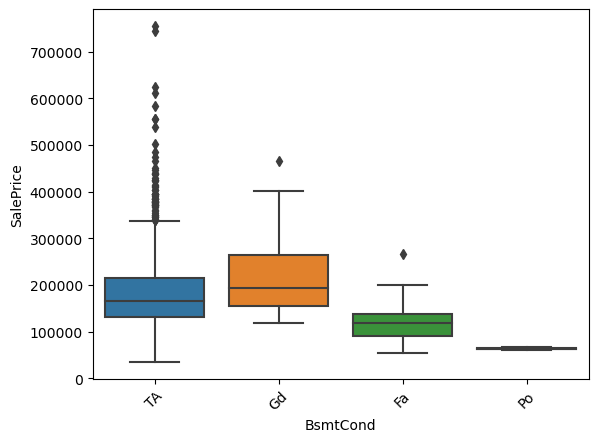

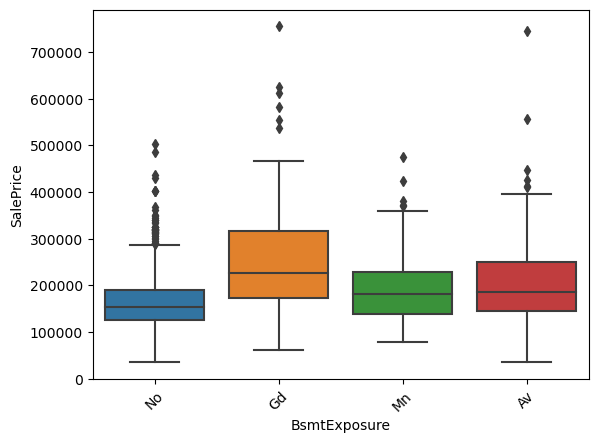

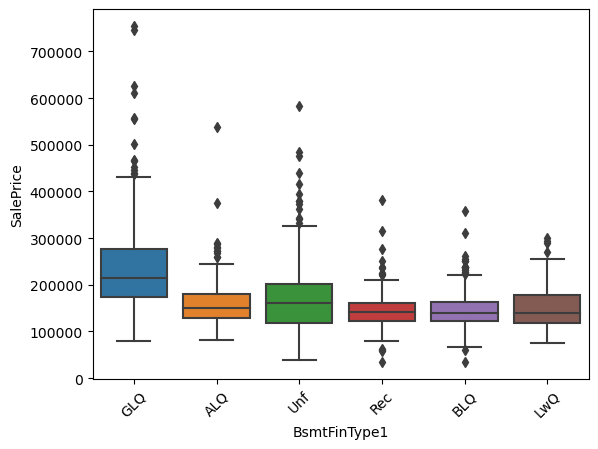

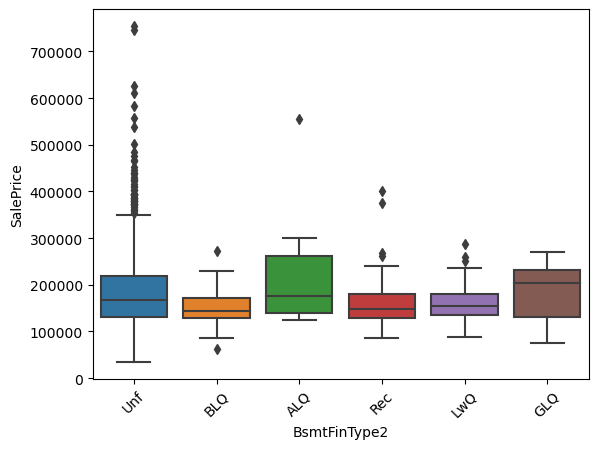

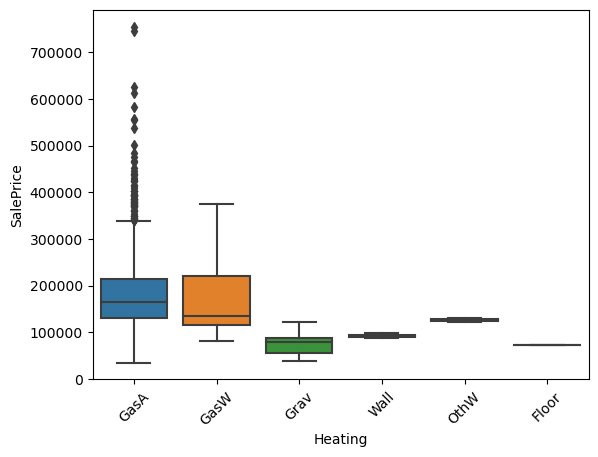

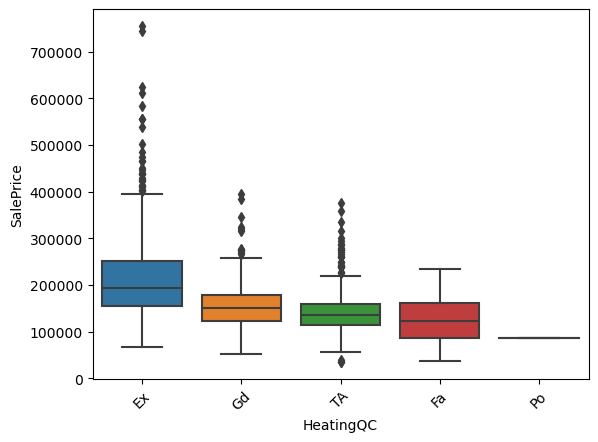

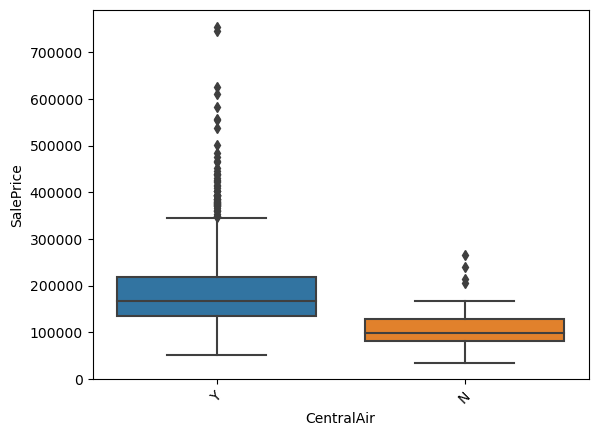

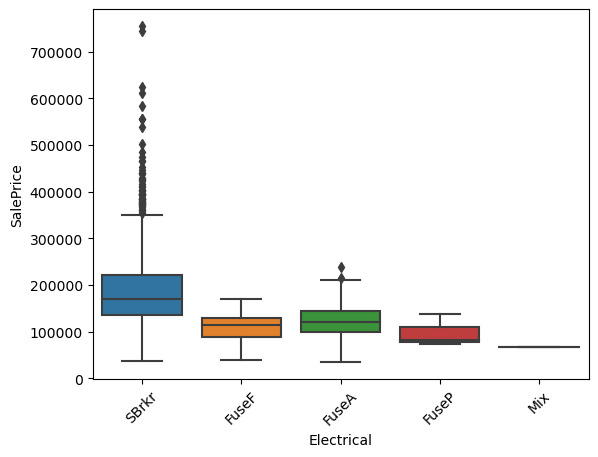

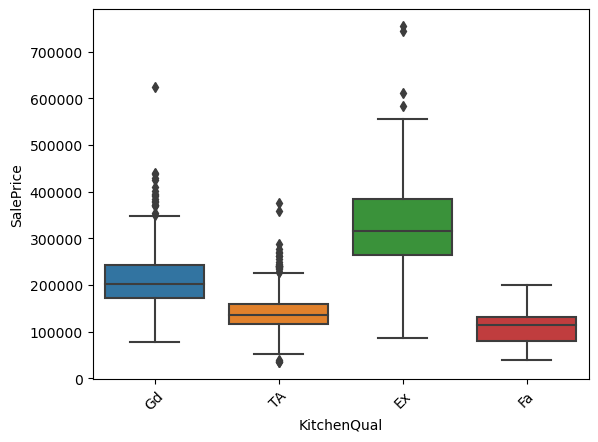

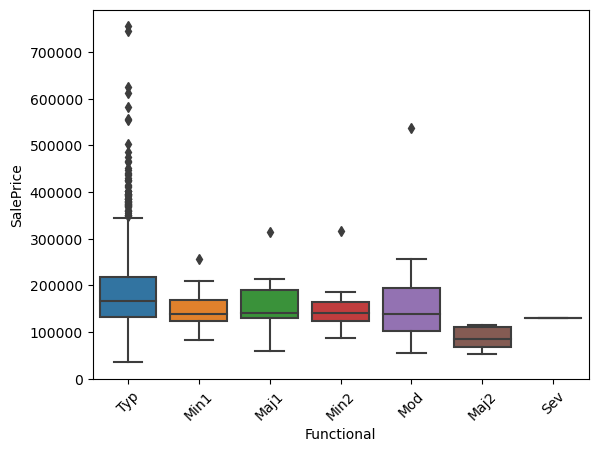

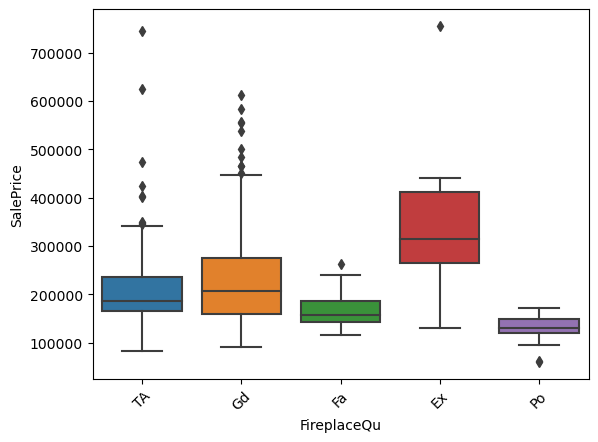

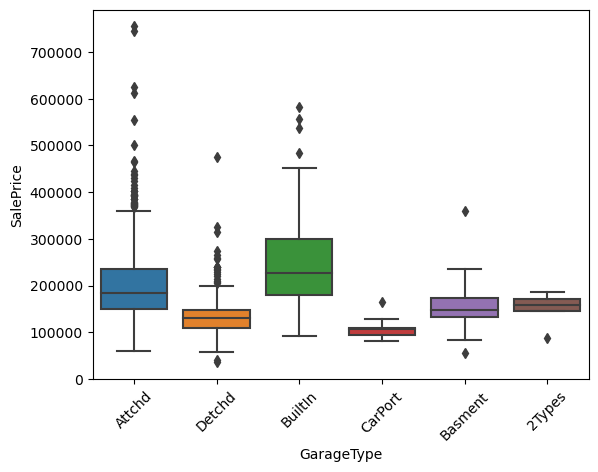

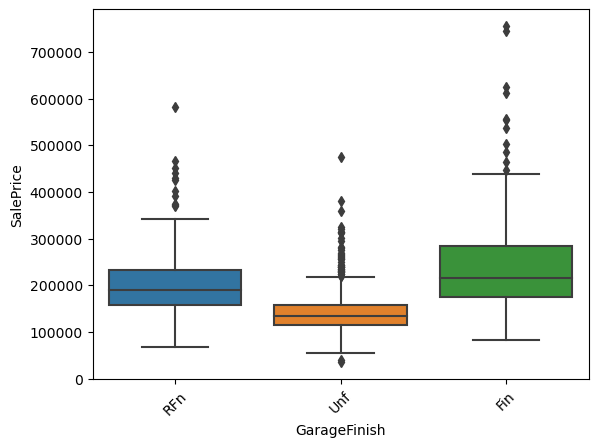

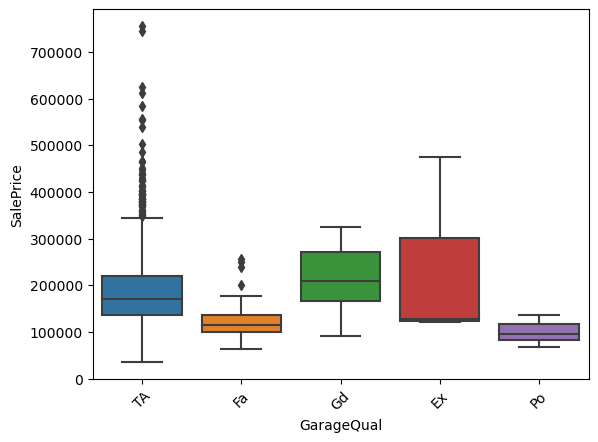

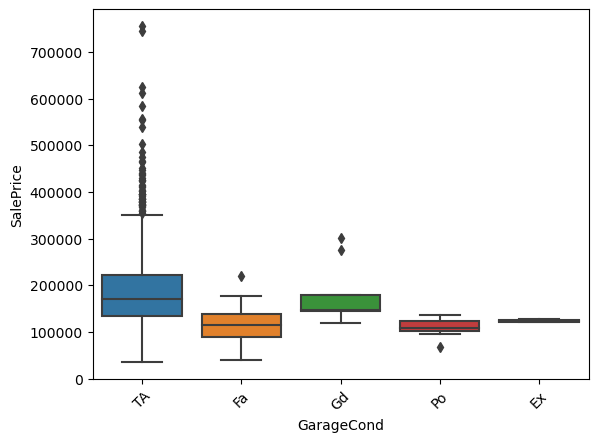

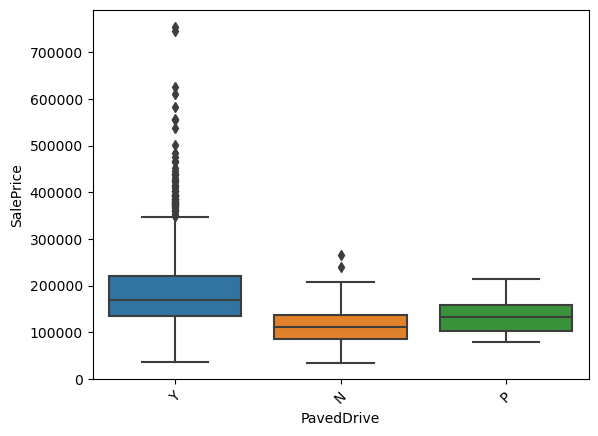

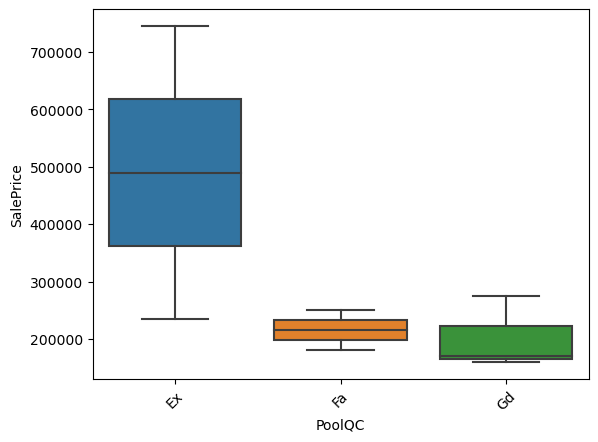

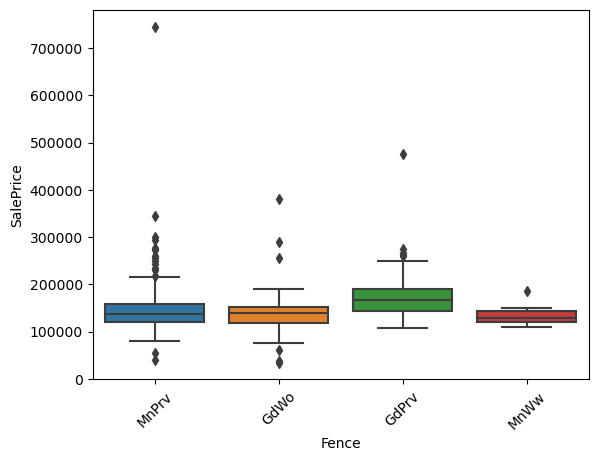

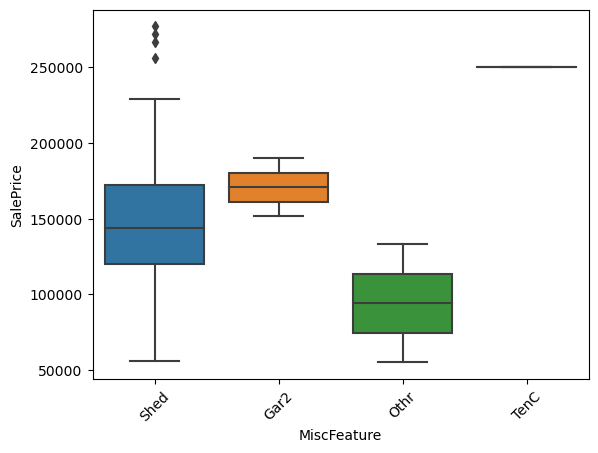

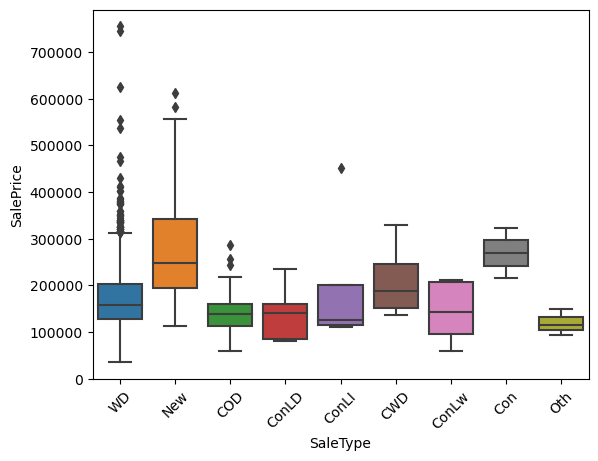

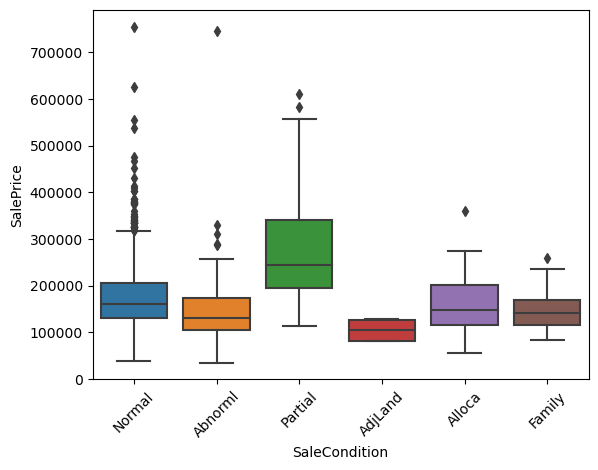

In [11]:
for i in train.columns:
    if train[i].dtype == "object" and i != "SalePrice":
        sns.boxplot(x=train[i], y=train["SalePrice"])
        plt.xlabel(i)
        plt.ylabel("SalePrice")
        plt.xticks(rotation=45)
        plt.show()

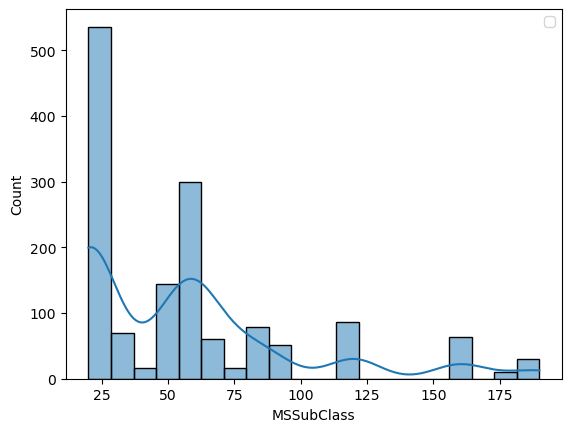

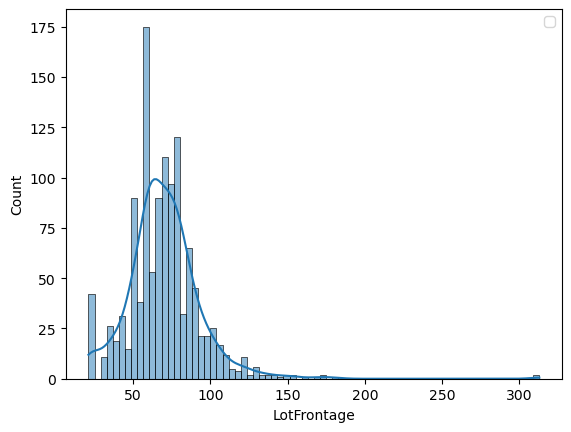

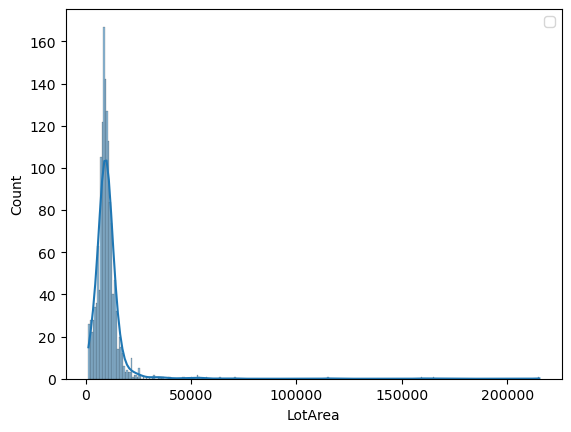

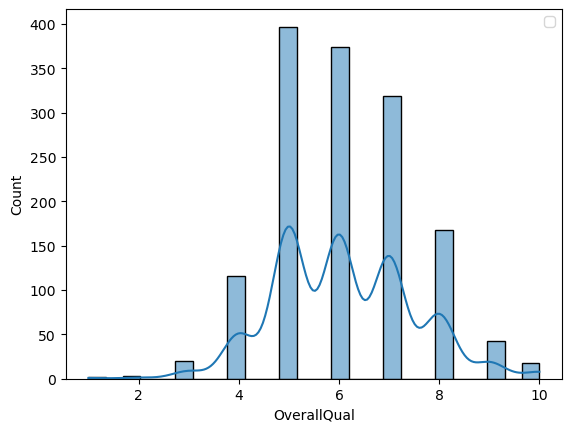

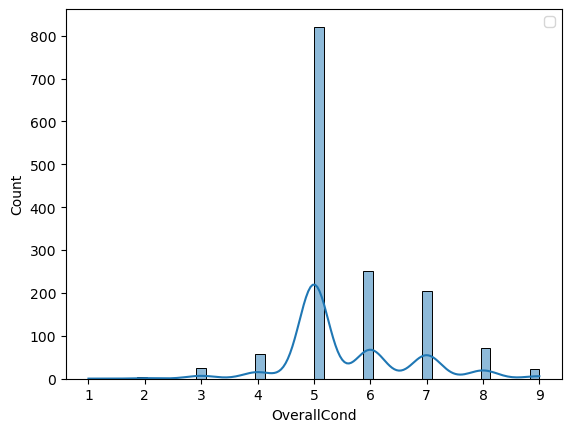

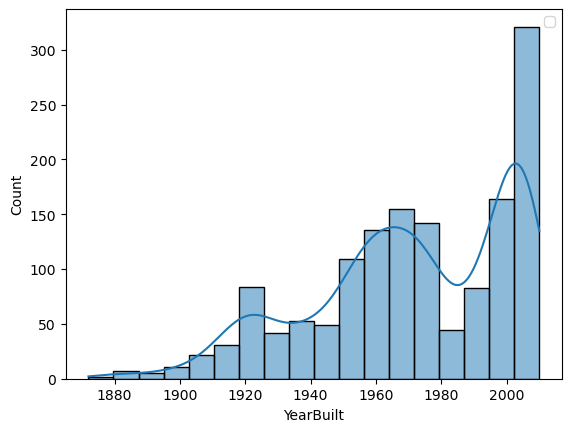

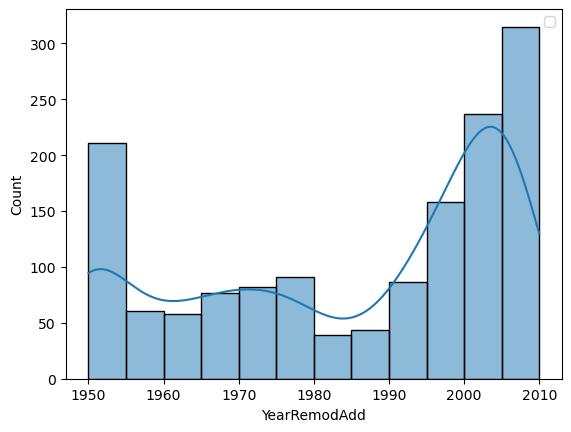

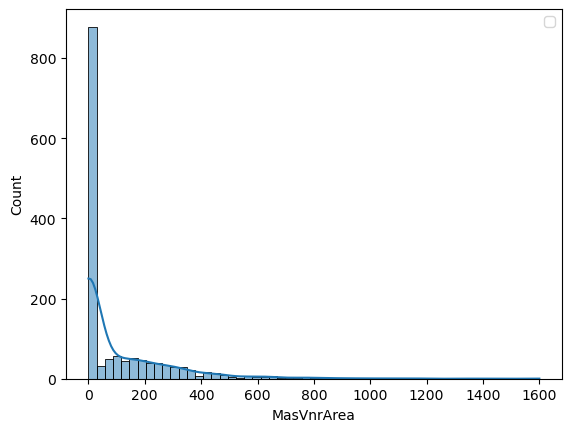

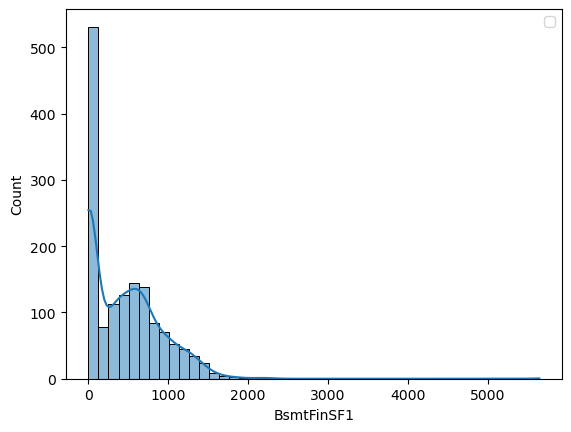

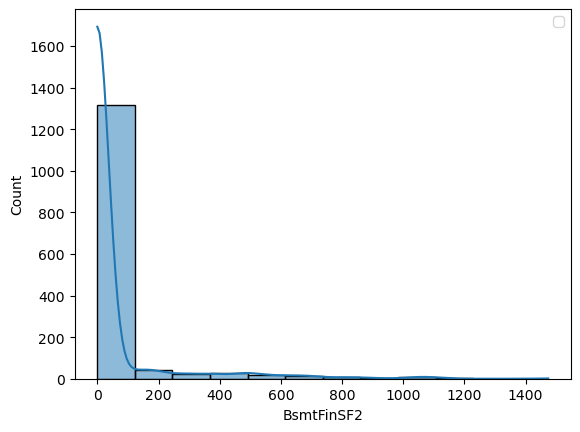

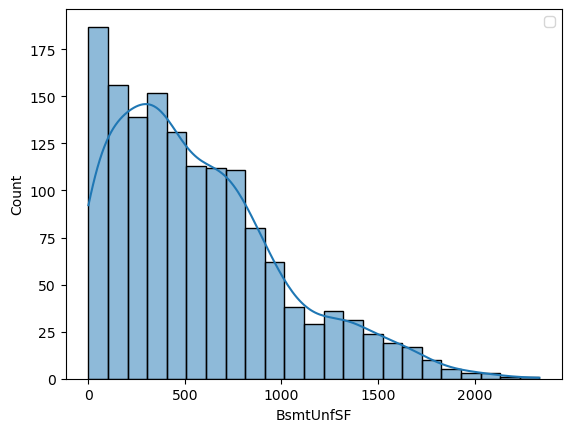

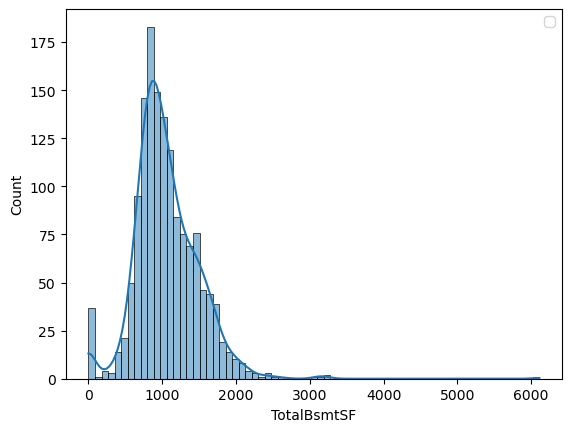

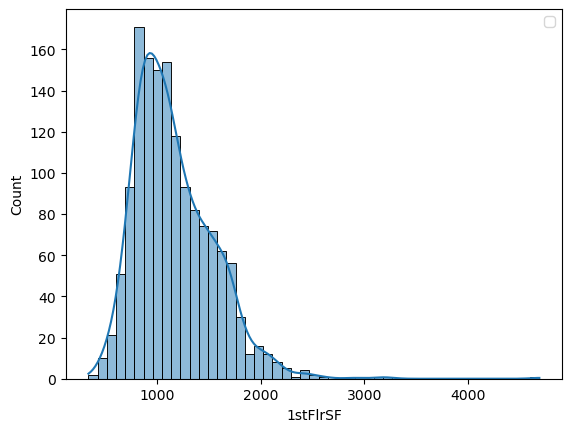

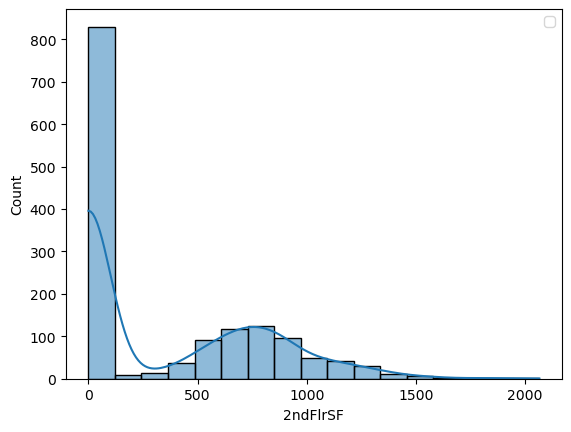

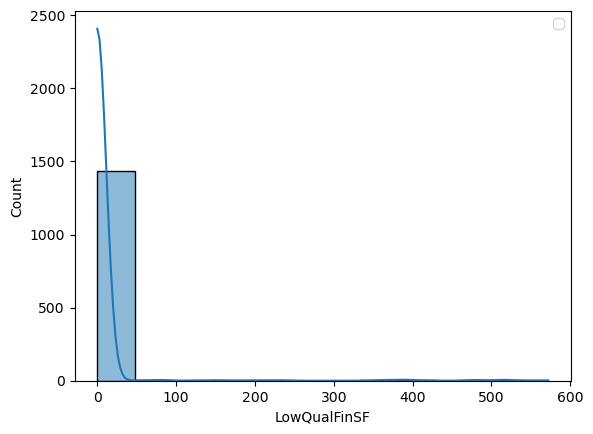

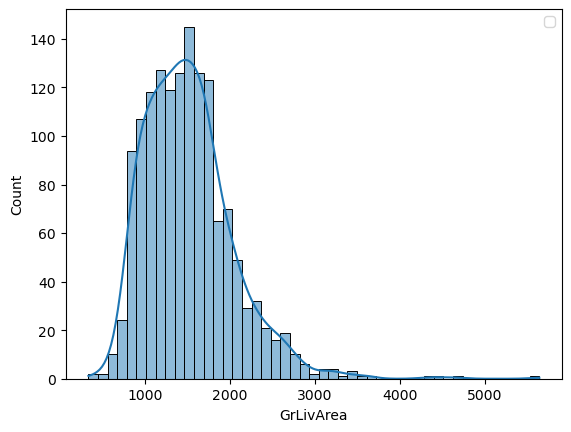

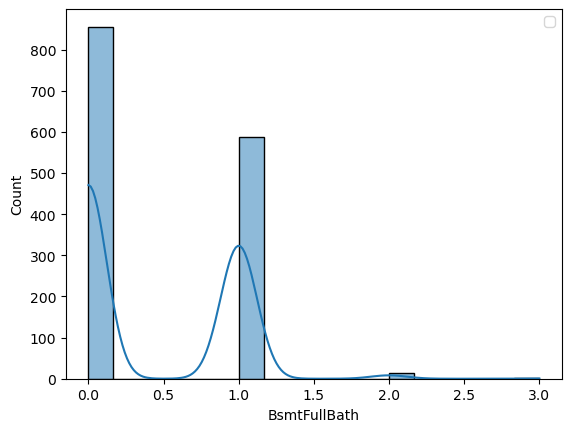

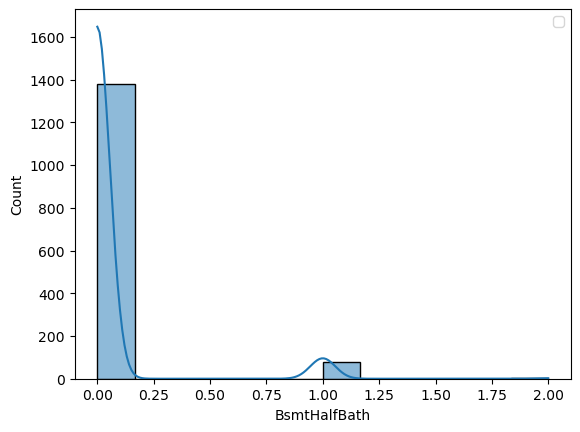

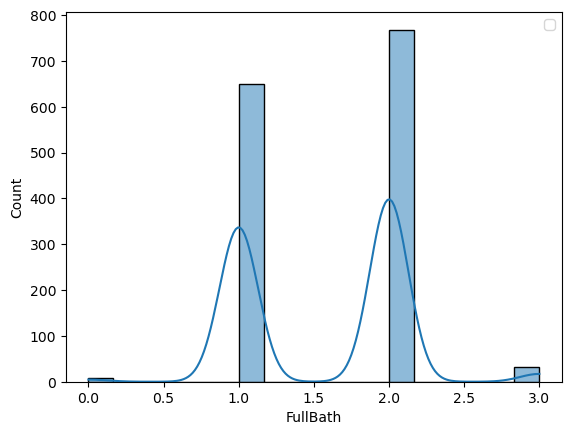

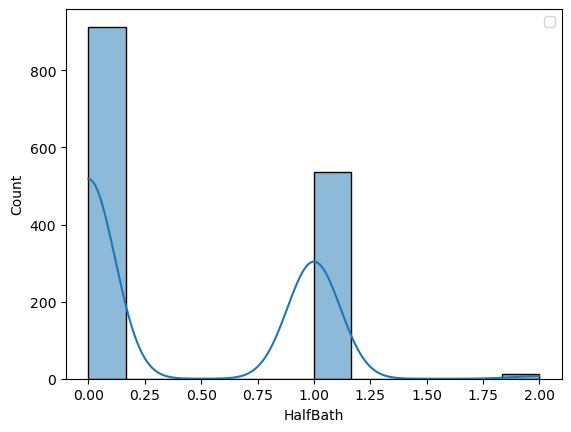

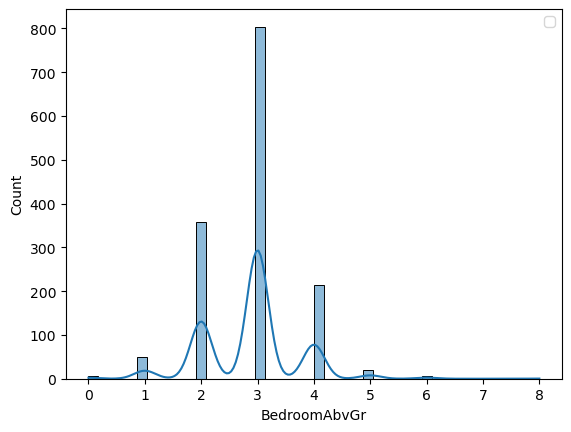

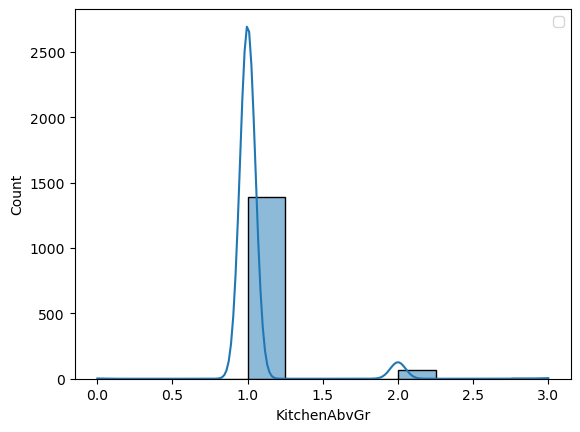

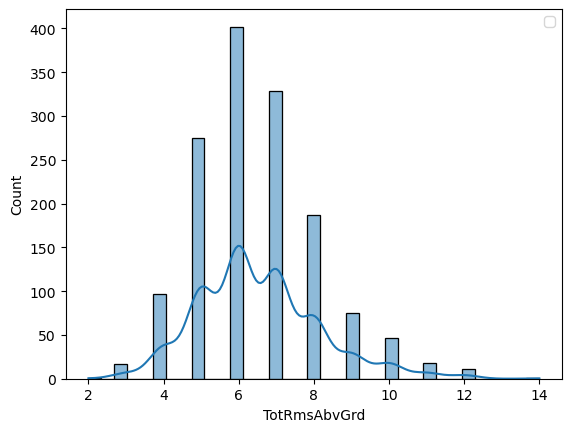

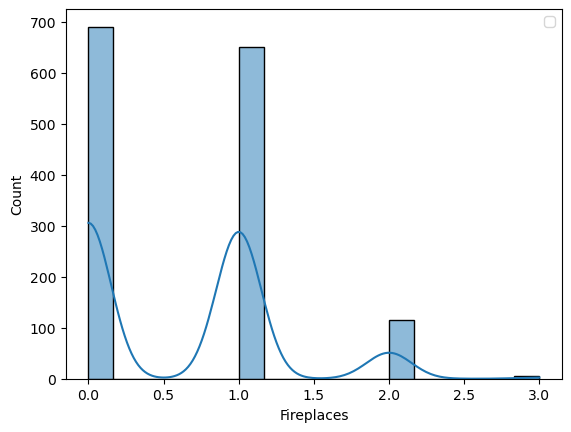

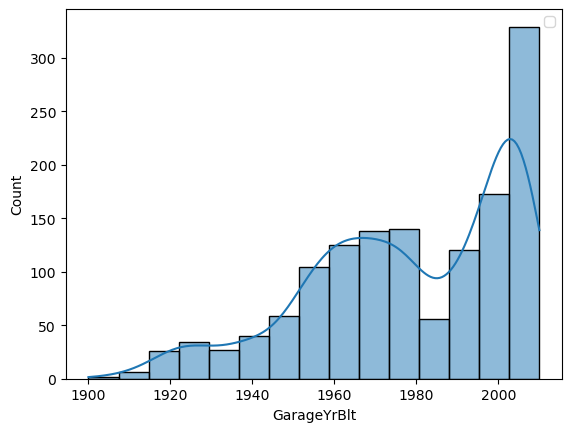

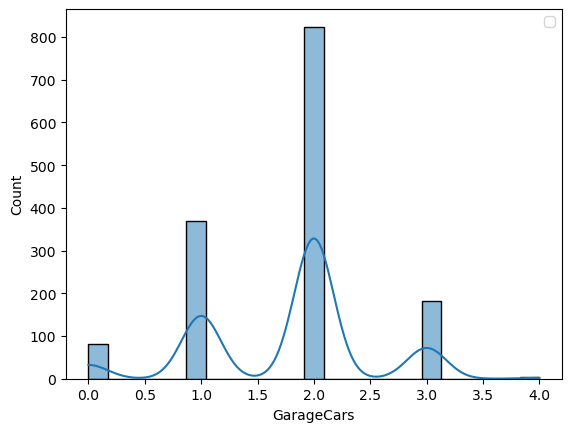

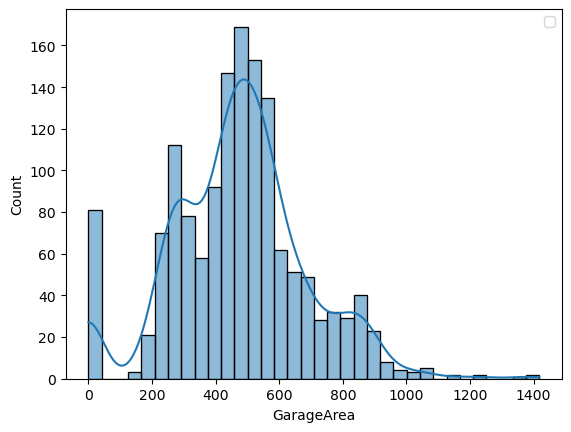

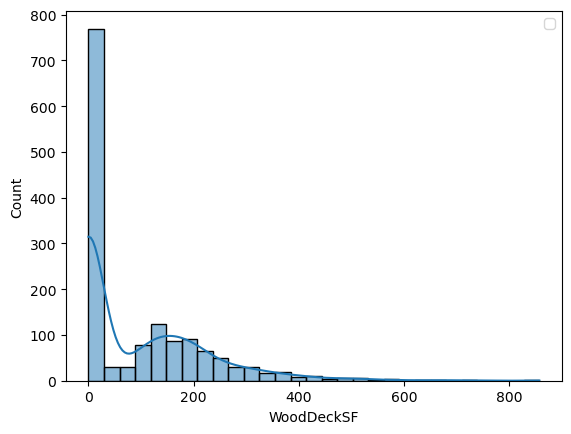

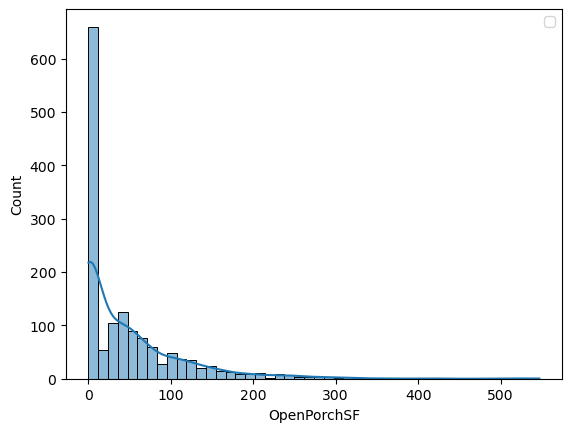

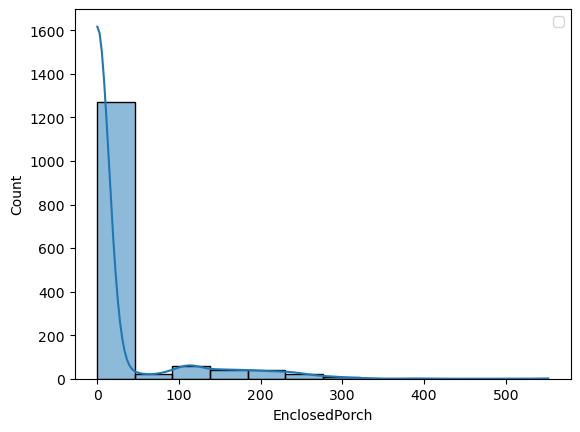

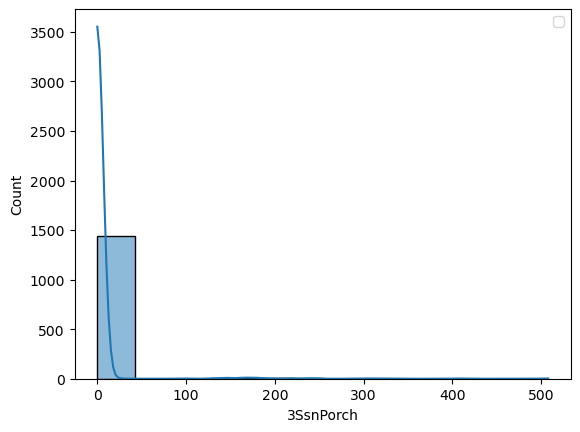

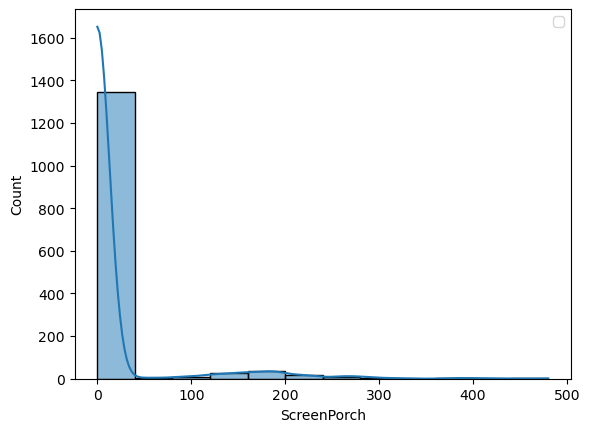

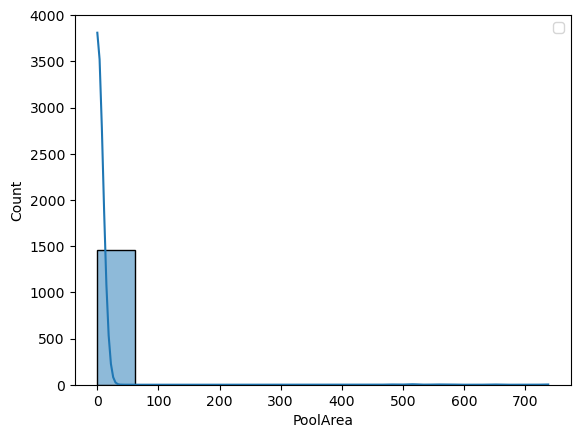

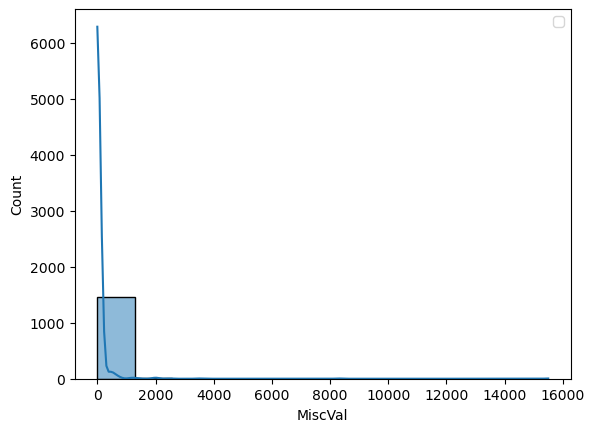

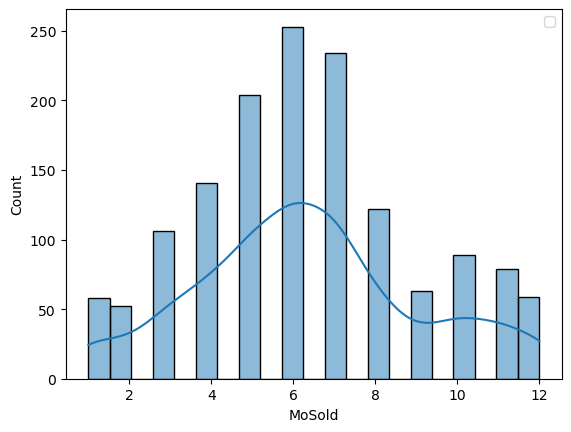

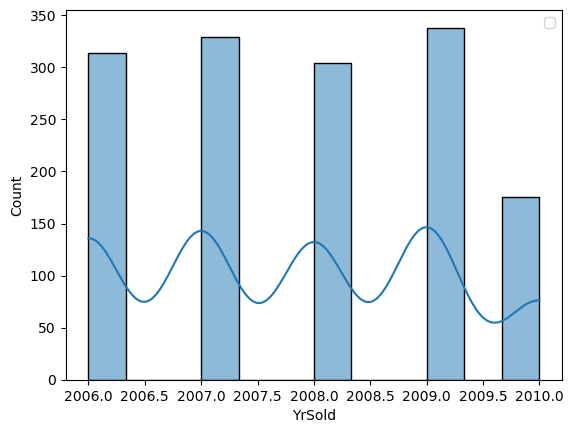

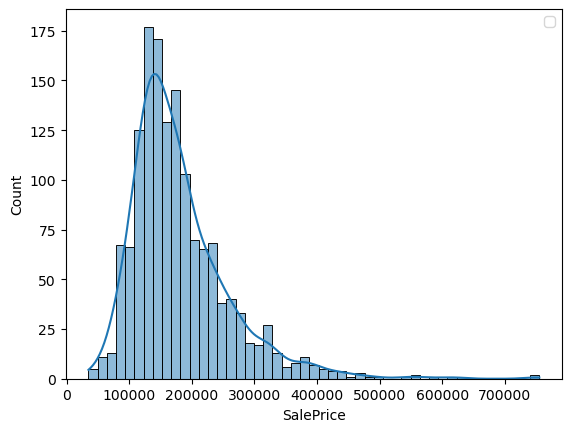

In [12]:
for i in train.columns:
    if train[i].dtype !="object":
        sns.histplot(x=train[i],kde=True)
        plt.xlabel(i)
        plt.legend()
        plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in train.columns:
    if train[i].dtype=="object":
        train[i]=le.fit_transform(train[i])

In [14]:
null_val=train.isnull().sum()
col_null=null_val[null_val>0].index

In [15]:
for i in col_null:
    train[i]=train[i].fillna(train[i].mean)
    
    

In [16]:
correlation_matrix = train.corr()['SalePrice']
correlation_matrix[correlation_matrix>0.5]

/tmp/ipykernel_20/2059229038.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()['SalePrice']


OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [17]:
correlation_matrix[correlation_matrix< -0.5]

ExterQual      -0.636884
BsmtQual       -0.620886
KitchenQual    -0.589189
GarageFinish   -0.549247
Name: SalePrice, dtype: float64

In [18]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   int64 
 2   LotFrontage    1460 non-null   object
 3   LotArea        1460 non-null   int64 
 4   Street         1460 non-null   int64 
 5   Alley          1460 non-null   int64 
 6   LotShape       1460 non-null   int64 
 7   LandContour    1460 non-null   int64 
 8   Utilities      1460 non-null   int64 
 9   LotConfig      1460 non-null   int64 
 10  LandSlope      1460 non-null   int64 
 11  Neighborhood   1460 non-null   int64 
 12  Condition1     1460 non-null   int64 
 13  Condition2     1460 non-null   int64 
 14  BldgType       1460 non-null   int64 
 15  HouseStyle     1460 non-null   int64 
 16  OverallQual    1460 non-null   int64 
 17  OverallCond    1460 non-null   int64 
 18  YearBuilt      1460 non-null

In [19]:
train["MasVnrArea"]=pd.to_numeric(train["MasVnrArea"],errors="coerce")
train["GarageYrBlt"]=pd.to_numeric(train["GarageYrBlt"],errors="coerce")
train["LotFrontage"]=pd.to_numeric(train["LotFrontage"],errors="coerce")
train["MasVnrArea"]=train["MasVnrArea"].astype("float")
train["GarageYrBlt"]=train["GarageYrBlt"].astype("float")
train["LotFrontage"]=train["LotFrontage"].astype("float")

In [20]:
data_null=train.isnull().sum()[train.isnull().sum() > 0].index
data_null

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [21]:
train.dropna(inplace=True)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1121 non-null   int64  
 1   MSZoning       1121 non-null   int64  
 2   LotFrontage    1121 non-null   float64
 3   LotArea        1121 non-null   int64  
 4   Street         1121 non-null   int64  
 5   Alley          1121 non-null   int64  
 6   LotShape       1121 non-null   int64  
 7   LandContour    1121 non-null   int64  
 8   Utilities      1121 non-null   int64  
 9   LotConfig      1121 non-null   int64  
 10  LandSlope      1121 non-null   int64  
 11  Neighborhood   1121 non-null   int64  
 12  Condition1     1121 non-null   int64  
 13  Condition2     1121 non-null   int64  
 14  BldgType       1121 non-null   int64  
 15  HouseStyle     1121 non-null   int64  
 16  OverallQual    1121 non-null   int64  
 17  OverallCond    1121 non-null   int64  
 18  YearBuil

In [23]:
train.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [24]:
x=train
y=x.pop("SalePrice")


In [25]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=41)

# model training without removing outliers

In [26]:
model=XGBRegressor()

In [27]:
model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [28]:
gb_pred=model.predict(x_test)
gb_accuracy=mean_squared_error(y_test,gb_pred)
print(gb_accuracy)
print(np.sqrt(gb_accuracy))

1648892511.3321056
40606.5574917661


In [29]:
from sklearn.linear_model import LinearRegression,SGDRegressor,HuberRegressor,Ridge,RANSACRegressor,Lasso

In [30]:
linear=LinearRegression()
sgd=SGDRegressor()
hub=HuberRegressor()
ridge=Ridge(alpha=1.0)
lasso=Lasso()

In [31]:
linear.fit(x_train,y_train)
sgd.fit(x_train,y_train)
hub.fit(x_train,y_train)
ridge.fit(x_train,y_train)
lasso.fit(x_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Lasso()

In [32]:
linear_pred=linear.predict(x_test)
sgd_pred=sgd.predict(x_test)
hub_pred=hub.predict(x_test)
ridge_pred=ridge.predict(x_test)
lasso_pred=lasso.predict(x_test)

In [33]:

linear_accuracy=mean_squared_error(y_test,linear_pred)
print("Linear Regression MSE",linear_accuracy)
print("Linear Regression RMSE",np.sqrt(linear_accuracy))

Linear Regression MSE 3712778128.3056436
Linear Regression RMSE 60932.570340546474


In [34]:

sgd_accuracy=mean_squared_error(y_test,sgd_pred)
print("SGD Regression MSE",sgd_accuracy)
print("SGD Regression RMSE",np.sqrt(sgd_accuracy))

SGD Regression MSE 5.858556397938338e+33
SGD Regression RMSE 7.654120718892757e+16


In [35]:

hub_accuracy=mean_squared_error(y_test,hub_pred)
print("Huber Regression MSE",hub_accuracy)
print("Huber Regression RMSE",np.sqrt(hub_accuracy))

Huber Regression MSE 4409279386.936425
Huber Regression RMSE 66402.40497855801


In [36]:

ridge_accuracy=mean_squared_error(y_test,ridge_pred)
print("Ridge Regression MSE",ridge_accuracy)
print("Ridge Regression RMSE",np.sqrt(ridge_accuracy))

Ridge Regression MSE 3593158969.1962037
Ridge Regression RMSE 59942.964301043736


In [37]:

lasso_accuracy=mean_squared_error(y_test,lasso_pred)
print("Lasso Regression MSE",linear_accuracy)
print("Lasso Regression RMSE",np.sqrt(lasso_accuracy))

Lasso Regression MSE 3712778128.3056436
Lasso Regression RMSE 60791.91059901729


# now apply PCA and then see the answer

In [38]:
from sklearn.decomposition import PCA

In [39]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import numpy as np

# Assuming you have features X and target variable y

# Create a dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'SGD Regression': SGDRegressor(),
    'Huber Regression': HuberRegressor(max_iter=1000),  # Adjust max_iter as needed
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

# Define the number of folds for cross-validation
num_folds = 5  # You can adjust this as needed

# Perform cross-validation for each model
for model_name, model in models.items():
    print("-----------------------------------------------", model_name, '-----------------------------------------------------------')
    
    # Create a pipeline for each model with scaling if necessary
    if model_name != 'SGD Regression':
        # For SGD Regression, scaling is handled internally
        model = make_pipeline(StandardScaler(), model)
    
    # Perform cross-validation using KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Use cross_val_score to get cross-validated scores
    cv_scores = cross_val_score(model, x, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Convert negative MSE to positive RMSE
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    # Print the cross-validated RMSE scores
    print(f"Cross-validated RMSE scores for {model_name}:", cv_rmse_scores)
    print(f"Mean RMSE for {model_name}:", np.mean(cv_rmse_scores))
    print()


----------------------------------------------- Linear Regression -----------------------------------------------------------
Cross-validated RMSE scores for Linear Regression: [43234.22921783 28314.69746173 39649.92490856 33219.53111988
 51476.02976824]
Mean RMSE for Linear Regression: 39178.882495247875

----------------------------------------------- SGD Regression -----------------------------------------------------------
Cross-validated RMSE scores for SGD Regression: [1.15082570e+17 7.39833115e+16 1.49051951e+16 7.11561853e+16
 5.63106200e+16]
Mean RMSE for SGD Regression: 6.628757634011433e+16

----------------------------------------------- Huber Regression -----------------------------------------------------------
Cross-validated RMSE scores for Huber Regression: [33827.21200341 25801.28145169 38681.66277688 31013.25869846
 55938.12829956]
Mean RMSE for Huber Regression: 37052.30864600187

----------------------------------------------- Ridge Regression ---------------------

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e+09, tolerance: 5.920e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.571e+08, tolerance: 6.231e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.512e+09, tolerance: 6.054e

Cross-validated RMSE scores for Lasso Regression: [43233.13611758 28318.79518554 39660.73184594 33219.45093206
 51483.17338274]
Mean RMSE for Lasso Regression: 39183.05749277194



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.665e+08, tolerance: 6.448e+08
  model = cd_fast.enet_coordinate_descent(
